### Init

In [7]:
from dotenv import load_dotenv
import sys, os 
from lib.seed import seed_prefix 
load_dotenv()

seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [8]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
train_df, test_df = data_split(data_df, split_num = 5)
train_df, valid_df = data_split(train_df, split_num = 5)

In [9]:
from lib.dataset import PCOS_Dataset
import torchvision.transforms as T
from torchvision.transforms import v2

binary_use = False
train_dataset = PCOS_Dataset(
    data_filenames = train_df['filename'],
    data_dir_path  = data_dir,
    labels         = train_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        # v2.CenterCrop(224),           # 224x224 중앙 자르기 -> 0.7977
        v2.RandomResizedCrop(224),           # 224x224 렌담 중앙 자르기 -> 0.8089
        # Augmenttation 추가
        # RandomEqualize(p=0.5),    # Histogram Equalized
        v2.RandomRotation(degrees = 15), # 랜덤 회전
        v2.RandomHorizontalFlip(p = 0.5),    # 랜덤 수평 뒤집기
        v2.RandomVerticalFlip(p = 0.5), # 랜덤 수직 뒤집기
        # Default Augmentation
        v2.Grayscale(num_output_channels=3),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환 
        v2.RandomApply([v2.GaussianNoise(mean = 0, sigma = 0.1, clip = True)], p=0.5), # 가우시안 노이즈
        # v2.RandomApply([v2.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.))], p=0.5), # 가우시안 Blur
        # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet 정규화 -> 0.7119
    ])
)

valid_dataset = PCOS_Dataset(
    data_filenames = valid_df['filename'],
    data_dir_path  = data_dir,
    labels         = valid_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    transform = T.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop((224, 224)),
        v2.Grayscale(num_output_channels=3),
        v2.ToTensor(),
    ])
)



[Alert] Sample Dataset Use : False
[Alert] Sample Dataset Use : False


/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


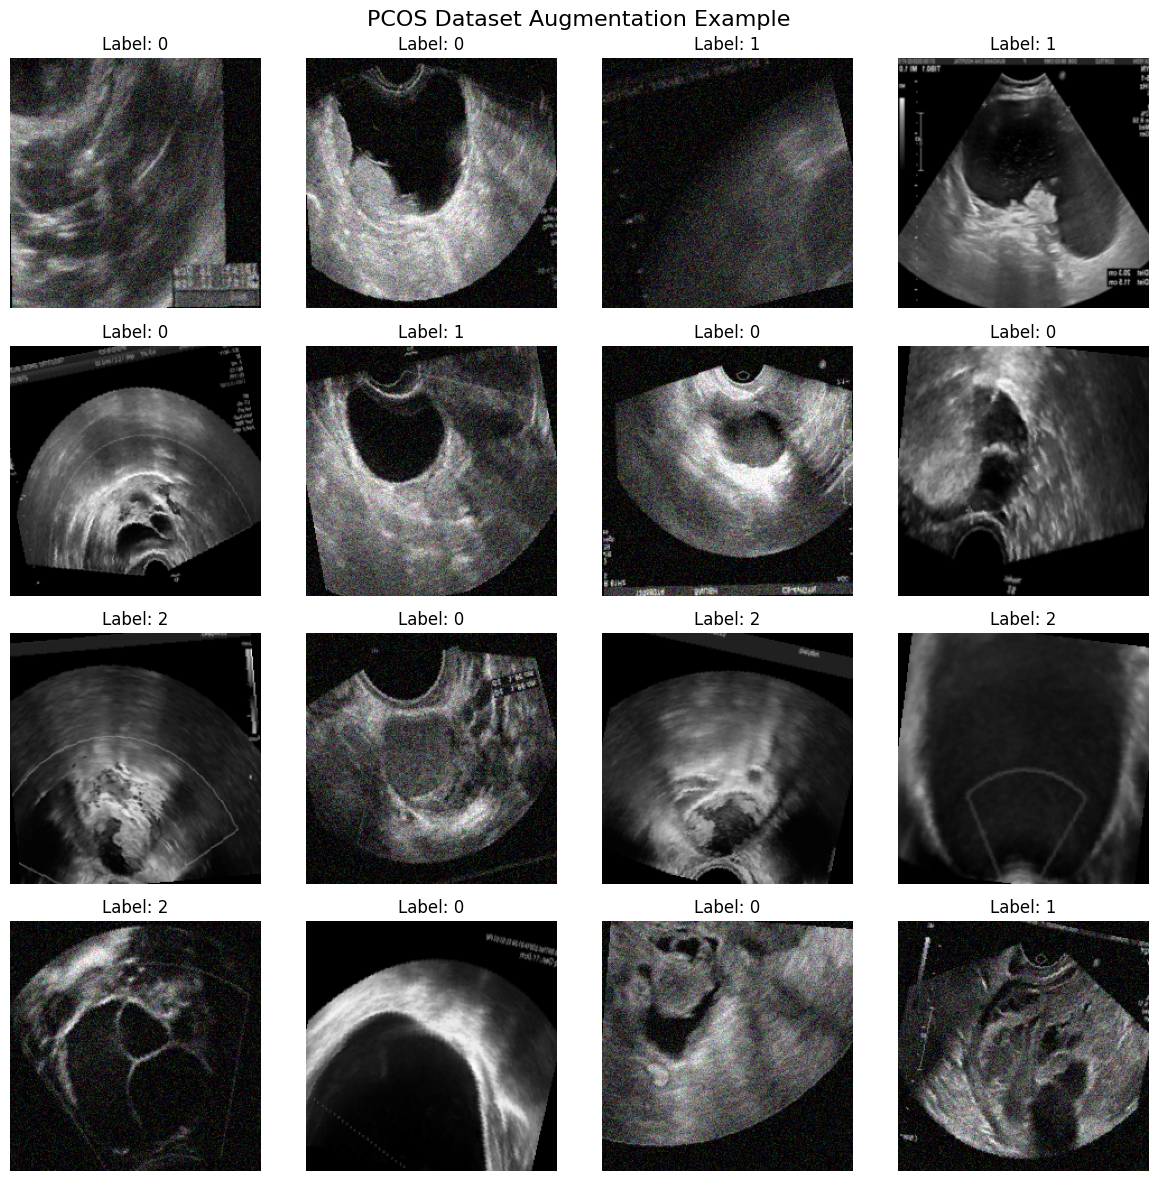

In [10]:
from torch.utils.data import DataLoader
from lib.sampler import BalancedBatchSampler
train_bs = 24
valid_bs = 8

# Sampler Not Use
train_loader = DataLoader(train_dataset, batch_size = train_bs, shuffle = True, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )

valid_loader = DataLoader(valid_dataset, batch_size = valid_bs, shuffle = False, pin_memory=True, pin_memory_device= "cuda:0", persistent_workers=True, prefetch_factor = 4, num_workers= 8, )

#%% Test Augmentation 
X, y = next(iter(train_loader))
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize = (12, 12))
fig.suptitle('PCOS Dataset Augmentation Example', fontsize = 16)
for i in range(16):
    axes[i//4, i%4].imshow(X[i].cpu().permute(1, 2, 0).numpy())
    axes[i//4, i%4].set_title(f'Label: {y[i].item()}')
    axes[i//4, i%4].axis('off')

plt.tight_layout()
plt.show()

# Model Load

In [11]:
import torch 
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### [Settings] Train - Hyper Parmas 정의

In [12]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime
from sklearn.metrics import roc_auc_score
import json
from loss import Poly1FocalLoss, Poly1CrossEntropyLoss
import datetime

# Training 

In [7]:
model_names = [
    'convnext_s',
    'dinov2_vits14_lc',
    'maxvit_t',
    'mobilenet_l',
    'resnet_18',
    'vit_l_16'
]
#%% [Init Experiment]
# exp_date= datetime.datetime.now().strftime('%y%m%d%H%M')
exp_date = "라벨변경전_multi"
for model_name in model_names:
    #%% [Model]
    print(f"[Info] Model : {model_name}")
    from models import Model_Loader
    num_classses = 1 if binary_use else 3
    model = Model_Loader(model_name = model_name, num_classes = num_classses).to('cuda')
    
    #%% [Init Tuner]
    Epoch = 100
    loss_label_smoothing = 0.1
    patience = 15
    lr = 0.0000013301
    #%% Loss 

    if binary_use:
        # 바이너리 분류에서는 pos_weight를 reshape하지 않고 직접 사용
        criterion = Poly1FocalLoss(
            num_classes = num_classses,
            reduction = 'mean',
            label_is_onehot = True,
            pos_weight = torch.tensor([3.]).to(device) # Poly1Focal for binary
        ).to(device)
    else:
        # criterion = nn.CrossEntropyLoss(label_smoothing = loss_label_smoothing).to(device) # CE
        criterion = Poly1CrossEntropyLoss(
            num_classes= num_classses, 
            reduction = 'mean'
        ).to(device) # Poly1CE

    #     # 다중 분류에서는 pos_weight 크기를 클래스 수에 맞게 조정
    #     criterion = Poly1FocalLoss(
    #         num_classes = num_classses, 
    #         reduction = 'mean', 
    #         label_is_onehot = False, 
    #         pos_weight = torch.tensor([1., 5., 5.]).to(device)
    #     ).to(device) # Poly1Focal

    optimizer = optim.Adam(model.parameters(), lr=lr)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True) # Loss 기준
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=patience, verbose=True) # AUC 기준

    exp_dir= f"/home/eiden/eiden/PCOS-roi-classification/v2/log/{exp_date}"
    os.makedirs(exp_dir, exist_ok=True)
    #%% [Trainer]
    best_val_auc = 0.0
    no_improve_count = 0

    for epoch in range(1, Epoch + 1):
        ##############################
        # 1) Training Loop
        ##############################
        model.train()
        train_loss = 0
        train_prob = []
        train_label = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            
            optimizer.zero_grad()

            # Forward
            y_res = model(X).view(-1)
            loss = criterion(y_res, y)
            
            # Backprop
            loss.backward()
            optimizer.step()
            
            # 누적
            train_loss += loss.item()
            # 예측값
            if binary_use:
                prob = torch.sigmoid(y_res).detach().cpu()
            else:
                prob = F.softmax(y_res, dim=1).detach().cpu()  # dim=1로 수정 (배치 내 각 샘플에 대해 확률 계산)
            train_prob.append(prob)
            train_label.append(y.detach().cpu())
            
        # -- Epoch 단위로 평균 Loss 계산
        train_loss = train_loss / len(train_loader)
        
        # -- 전체 batch의 예측 결과 / 실제 라벨 붙이기
        train_pred = torch.cat(train_prob, dim=0)
        train_label = torch.cat(train_label, dim=0)
        
        # -- ROC AUC 계산 (binary와 multi 모두 지원)
        if binary_use:
            # 바이너리 분류의 경우 단순히 양성 클래스의 확률만 사용
            train_auc = roc_auc_score(train_label.numpy(), train_pred.numpy())
        else:
            # 다중 분류의 경우 각 클래스별 확률 사용 (합이 1이 되도록 함)
            train_auc = roc_auc_score(
                train_label.numpy(), 
                train_pred.numpy(), 
                multi_class='ovr',
                average='macro'
            )

        ##############################
        # 2) Validation Loop
        ##############################
        model.eval()
        val_loss = 0
        val_prob = []
        val_label = []
        
        with torch.no_grad():
            for X_val, y_val in valid_loader:
                X_val = X_val.to(device)
                y_val = y_val.to(device)
                
                y_res_val = model(X_val).view(-1)
                loss_val = criterion(y_res_val, y_val)  # y_res_val로 수정
                val_loss += loss_val.item()
                
                if binary_use:
                    val_prob.append(torch.sigmoid(y_res_val).cpu())
                else:
                    val_prob.append(F.softmax(y_res_val, dim=1).cpu())  # dim=1로 수정
                val_label.append(y_val.cpu())
        
        val_loss /= len(valid_loader)
        
        #%% Validation AUC 계산
        val_pred = torch.cat(val_prob, dim=0)
        val_label = torch.cat(val_label, dim=0)
        
        if binary_use:
            # 바이너리 분류의 경우
            val_auc = roc_auc_score(val_label.numpy(), val_pred.numpy())
        else:
            # 다중 분류의 경우
            val_auc = roc_auc_score(
                val_label.numpy(),
                val_pred.numpy(),
                multi_class='ovr',
                average='macro'
            )
        scheduler.step(val_auc)
        
        # print(f"[Epoch {epoch}/{Epoch}] "
        #     f"Train Loss: {train_loss:.4f}, Train AUC: {train_auc:.4f} | "
        #     f"Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

        ##############################
        # 3) Early Stopping + Model Save
        ##############################
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            no_improve_count = 0
            
            # 베스트 모델 갱신 -> 저장
            save_model_path = f"{exp_dir}/{model_name}.pth"
            torch.save(model.state_dict(), save_model_path)
            
            # json파일도 하나 만들어서 Metric 저장
            save_json_path = f"/home/eiden/eiden/PCOS-roi-classification/v2/log/{exp_date}/{model_name}.json"
            with open(save_json_path, 'w') as f:
                json.dump({
                    'best_val_auc': best_val_auc,
                    'train_auc': train_auc,
                    'val_auc': val_auc,
                    'exp_date': exp_date,
                    'model_path': save_model_path
                }, f)
            print(f"  >> Best model updated! (AUC={best_val_auc:.4f}) <<")
        else:
            no_improve_count += 1
        
        # 15 epoch 동안 AUC 개선이 없으면 중단
        if no_improve_count >= patience:
            print(f"  >> Best model updated! (AUC={best_val_auc:.4f}) <<")
            print("Early stopping triggered!")
            break
    
    # 모델 학습 완료 후 메모리 정리
    del model
    del criterion
    del optimizer
    del scheduler
    torch.cuda.empty_cache()

[Info] Model : convnext_s


/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Small_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  >> Best model updated! (AUC=0.4777) <<
  >> Best model updated! (AUC=0.4976) <<
  >> Best model updated! (AUC=0.5109) <<
  >> Best model updated! (AUC=0.5239) <<
  >> Best model updated! (AUC=0.5430) <<
  >> Best model updated! (AUC=0.5591) <<
  >> Best model updated! (AUC=0.5767) <<
  >> Best model updated! (AUC=0.5845) <<
  >> Best model updated! (AUC=0.6009) <<
  >> Best model updated! (AUC=0.6109) <<
  >> Best model updated! (AUC=0.6265) <<
  >> Best model updated! (AUC=0.6310) <<
  >> Best model updated! (AUC=0.6433) <<
  >> Best model updated! (AUC=0.6464) <<
  >> Best model updated! (AUC=0.6528) <<
  >> Best model updated! (AUC=0.6625) <<
  >> Best model updated! (AUC=0.6743) <<
  >> Best model updated! (AUC=0.6851) <<
  >> Best model updated! (AUC=0.6954) <<
  >> Best model updated! (AUC=0.6986) <<
  >> Best model updated! (AUC=0.7025) <<
  >> Best model updated! (AUC=0.7166) <<
  >> Best model updated! (AUC=0.7191) <<
  >> Best model updated! (AUC=0.7218) <<
  >> Best model 

Using cache found in /home/eiden/.cache/torch/hub/facebookresearch_dinov2_main
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/eiden/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")
/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  >> Best model updated! (AUC=0.6511) <<
  >> Best model updated! (AUC=0.7176) <<
  >> Best model updated! (AUC=0.7473) <<
  >> Best model updated! (AUC=0.7724) <<
  >> Best model updated! (AUC=0.7898) <<
  >> Best model updated! (AUC=0.7927) <<
  >> Best model updated! (AUC=0.8054) <<
  >> Best model updated! (AUC=0.8062) <<
  >> Best model updated! (AUC=0.8182) <<
  >> Best model updated! (AUC=0.8190) <<
  >> Best model updated! (AUC=0.8341) <<
  >> Best model updated! (AUC=0.8422) <<
  >> Best model updated! (AUC=0.8439) <<
  >> Best model updated! (AUC=0.8492) <<
  >> Best model updated! (AUC=0.8494) <<
  >> Best model updated! (AUC=0.8516) <<
  >> Best model updated! (AUC=0.8541) <<
  >> Best model updated! (AUC=0.8548) <<
  >> Best model updated! (AUC=0.8563) <<
  >> Best model updated! (AUC=0.8594) <<
  >> Best model updated! (AUC=0.8639) <<
  >> Best model updated! (AUC=0.8666) <<
  >> Best model updated! (AUC=0.8697) <<
  >> Best model updated! (AUC=0.8697) <<
Early stopping t

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  >> Best model updated! (AUC=0.5104) <<
  >> Best model updated! (AUC=0.5226) <<
  >> Best model updated! (AUC=0.5356) <<
  >> Best model updated! (AUC=0.5473) <<
  >> Best model updated! (AUC=0.5586) <<
  >> Best model updated! (AUC=0.5679) <<
  >> Best model updated! (AUC=0.5776) <<
  >> Best model updated! (AUC=0.5805) <<
  >> Best model updated! (AUC=0.5854) <<
  >> Best model updated! (AUC=0.5920) <<
  >> Best model updated! (AUC=0.5953) <<
  >> Best model updated! (AUC=0.5967) <<
  >> Best model updated! (AUC=0.6035) <<
  >> Best model updated! (AUC=0.6085) <<
  >> Best model updated! (AUC=0.6119) <<
  >> Best model updated! (AUC=0.6161) <<
  >> Best model updated! (AUC=0.6192) <<
  >> Best model updated! (AUC=0.6201) <<
  >> Best model updated! (AUC=0.6239) <<
  >> Best model updated! (AUC=0.6258) <<
  >> Best model updated! (AUC=0.6291) <<
  >> Best model updated! (AUC=0.6356) <<
  >> Best model updated! (AUC=0.6389) <<
  >> Best model updated! (AUC=0.6423) <<
  >> Best model 

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  >> Best model updated! (AUC=0.3290) <<
  >> Best model updated! (AUC=0.3513) <<
  >> Best model updated! (AUC=0.3871) <<
  >> Best model updated! (AUC=0.3873) <<
  >> Best model updated! (AUC=0.4047) <<
  >> Best model updated! (AUC=0.4333) <<
  >> Best model updated! (AUC=0.4568) <<
  >> Best model updated! (AUC=0.4698) <<
  >> Best model updated! (AUC=0.4844) <<
  >> Best model updated! (AUC=0.4950) <<
  >> Best model updated! (AUC=0.5010) <<
  >> Best model updated! (AUC=0.5095) <<
  >> Best model updated! (AUC=0.5129) <<
  >> Best model updated! (AUC=0.5183) <<
  >> Best model updated! (AUC=0.5202) <<
  >> Best model updated! (AUC=0.5226) <<
  >> Best model updated! (AUC=0.5301) <<
  >> Best model updated! (AUC=0.5361) <<
  >> Best model updated! (AUC=0.5398) <<
  >> Best model updated! (AUC=0.5436) <<
  >> Best model updated! (AUC=0.5478) <<
  >> Best model updated! (AUC=0.5501) <<
  >> Best model updated! (AUC=0.5532) <<
  >> Best model updated! (AUC=0.5586) <<
  >> Best model 

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  >> Best model updated! (AUC=0.4642) <<
  >> Best model updated! (AUC=0.4781) <<
  >> Best model updated! (AUC=0.4836) <<
  >> Best model updated! (AUC=0.4973) <<
  >> Best model updated! (AUC=0.5356) <<
  >> Best model updated! (AUC=0.5685) <<
  >> Best model updated! (AUC=0.5762) <<
  >> Best model updated! (AUC=0.6056) <<
  >> Best model updated! (AUC=0.6191) <<
  >> Best model updated! (AUC=0.6244) <<
  >> Best model updated! (AUC=0.6436) <<
  >> Best model updated! (AUC=0.6587) <<
  >> Best model updated! (AUC=0.6616) <<
  >> Best model updated! (AUC=0.6767) <<
  >> Best model updated! (AUC=0.6876) <<
  >> Best model updated! (AUC=0.6876) <<
  >> Best model updated! (AUC=0.7021) <<
  >> Best model updated! (AUC=0.7069) <<
  >> Best model updated! (AUC=0.7111) <<
  >> Best model updated! (AUC=0.7200) <<
  >> Best model updated! (AUC=0.7252) <<
  >> Best model updated! (AUC=0.7307) <<
  >> Best model updated! (AUC=0.7427) <<
  >> Best model updated! (AUC=0.7559) <<
  >> Best model 

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  >> Best model updated! (AUC=0.6637) <<
  >> Best model updated! (AUC=0.7119) <<
  >> Best model updated! (AUC=0.7397) <<
  >> Best model updated! (AUC=0.7549) <<
  >> Best model updated! (AUC=0.7777) <<
  >> Best model updated! (AUC=0.7894) <<
  >> Best model updated! (AUC=0.7975) <<
  >> Best model updated! (AUC=0.8058) <<
  >> Best model updated! (AUC=0.8139) <<
  >> Best model updated! (AUC=0.8226) <<
  >> Best model updated! (AUC=0.8236) <<
  >> Best model updated! (AUC=0.8314) <<
  >> Best model updated! (AUC=0.8328) <<
  >> Best model updated! (AUC=0.8421) <<
  >> Best model updated! (AUC=0.8492) <<
  >> Best model updated! (AUC=0.8492) <<
Early stopping triggered!


model version = dinov2_vits14_lc Train 8GB / Inference 3GB
Binary
- linear layer(freeze) : 0.6971
- linear layer(fire) : 0.8732
- linear layer(fire) + 

Multi class
- linear layer(freeze) : 0.6364
- linear layer(fire) : 0.8217

model version = dinov2_vitb14_lc : Train 16GB / Inference 4GB
Binary
- linear layer(freeze) : 
- linear layer(fire) : 

Multi class
- linear layer(freeze) : 
- linear layer(fire) : 

